### Import Necessary Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.linalg import expm
from scipy.stats import linregress
import matplotlib.ticker as ticker
import time

## RK4 Implementation

In [7]:
# Classical 4th-order Runge-Kutta step
def rk4_step(f, t, y, h):
    k1 = f(t, y)
    k2 = f(t + h/2, y + h/2 * k1)
    k3 = f(t + h/2, y + h/2 * k2)
    k4 = f(t + h, y + h * k3)
    return y + (h/6) * (k1 + 2*k2 + 2*k3 + k4)

# Solve rocket dynamics using RK4
def solve_rk4(f, y0, t_max, num_steps):
    t_values = np.linspace(0, t_max, num_steps)
    h = t_max / (num_steps - 1)
    Y = np.zeros((num_steps, len(y0)))
    Y[0] = y0
    for i in range(num_steps-1):
        Y[i+1] = rk4_step(f, t_values[i], Y[i], h)
    return t_values, Y


## RK4 Stability

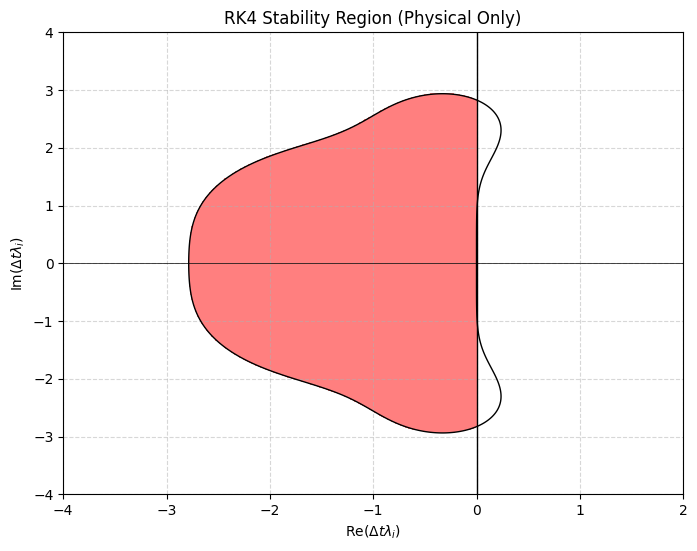

In [23]:
import numpy as np
import matplotlib.pyplot as plt

def R(z):
    """RK4 stability function"""
    return 1 + z + z**2/2 + z**3/6 + z**4/24

# Create grid
x = np.linspace(-4, 2, 500)
y = np.linspace(-4, 4, 500)
X, Y = np.meshgrid(x, y)
Z = X + 1j*Y

# Compute stability function
R_vals = R(Z)
R_abs = np.abs(R_vals)

# Create mask for physical stability region (Re(z) ≤ 0 and |R(z)| ≤ 1)
stability_mask = (X <= 0) & (R_abs <= 1)

# Create artificial boundary at x=0 for the contour
# Where the contour would appear in x>0, we'll make it vertical at x=0
zero_line = np.zeros_like(Y)
boundary_mask = (R_abs <= 1.01) & (R_abs >= 0.99)  # Capture contour points
boundary_mask = boundary_mask & (X > 0)  # Only for positive x

plt.figure(figsize=(8, 6))

# Plot stability region (red)
plt.contourf(X, Y, stability_mask, levels=[0.5, 1.5], colors=['red'], alpha=0.5)

# Plot main stability boundary (black)
plt.contour(X, Y, R_abs, levels=[1], colors='black', linewidths=1)

# Add vertical line at x=0 where contour would be in positive x region
plt.plot([0, 0], [y.min(), y.max()], 'black', linewidth=1)

# Axes and labels
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5, linestyle='--')
plt.xlabel(r'Re($\Delta t \lambda_i$)')
plt.ylabel(r'Im($\Delta t \lambda_i$)')
plt.title('RK4 Stability Region (Physical Only)')
plt.grid(True, linestyle='--', alpha=0.5)

plt.xlim(-4, 2)  # Maintain original x-range
plt.ylim(-4, 4)
plt.show()

## Rocket Dynamics for Convergence

This first function models the rocket dynamics with drag, but without factoring in burnout

In [19]:
# Define the rocket dynamics with drag
def rocket_with_drag(t, y):
    v = y[0]
    g = 9.81
    m = 1000 - 5 * t
    v_e = 3000
    mdot = -5
    C_d = 0.5
    rho_0 = 1.225
    H = 8500
    A = 1.0

    h = y[1]
    rho = rho_0 * np.exp(-h / H)

    drag = 0.5 * C_d * rho * A * v * abs(v) / m
    thrust = -v_e * mdot / m

    dvdt = thrust - g - drag
    dhdt = v

    return np.array([dvdt, dhdt])

This first function describes the rocket dynamics with drag, also factoring in burnout

In [16]:
def rocket_with_drag_and_burnout(t, y):
    v = y[0]  # velocity (m/s)
    h = y[1]  # altitude (m)

    # --- Physical constants ---
    g = 9.81
    m0 = 500.0
    mdot = 2.0
    v_e = 3000.0

    C_d = 0.5
    A = 0.1
    rho0 = 1.225
    H = 8500

    burn_time = m0 / mdot
    if t <= burn_time:
        m = m0 - mdot * t
        thrust = v_e * mdot / m
    else:
        m = m0 - mdot * burn_time
        thrust = 0.0

    rho = rho0 * np.exp(-h / H)
    drag = 0.5 * C_d * rho * A * v * abs(v) / m

    dvdt = thrust - g - drag
    dhdt = v

    return np.array([dvdt, dhdt])

## Convergence Studies

This first convergence study checks the convergence for RK4 by testing the rocket equation with drag, not factoring in burnout.

Observed convergence rate: 3.8756


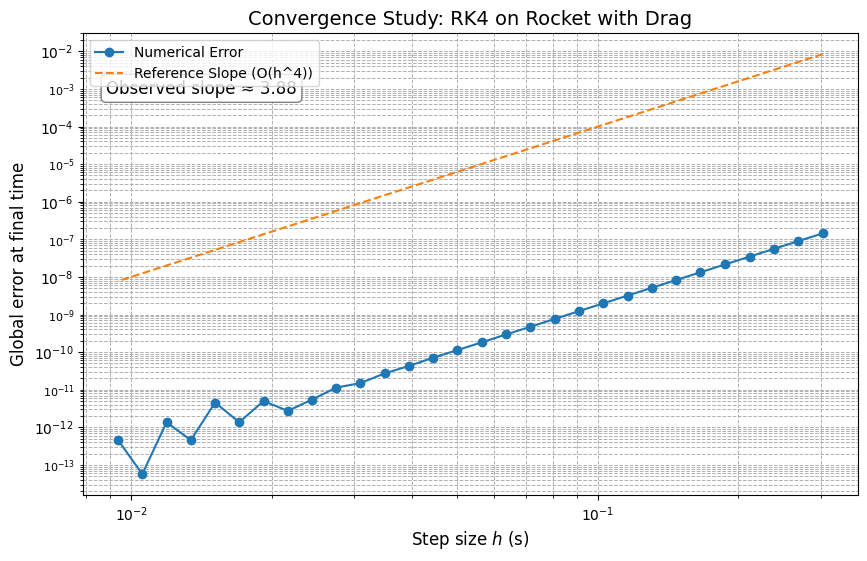

In [20]:
def convergence_study():
    t_max = 30
    y0 = np.array([0.0, 0.0])  # Initial [velocity, altitude]

    step_counts = np.round(np.logspace(np.log10(100), np.log10(3200), 30)).astype(int)
    errors = []

    # Reference solution
    t_ref, Y_ref = solve_rk4(rocket_with_drag, y0, t_max, 12800)
    final_ref = Y_ref[-1]

    for N in step_counts:
        t_num, Y_num = solve_rk4(rocket_with_drag, y0, t_max, N)
        final_num = Y_num[-1]
        error = np.linalg.norm(final_num - final_ref, ord=np.inf)
        errors.append(error)

    # Plotting
    hs = t_max / (np.array(step_counts) - 1)

    plt.figure(figsize=(10, 6))
    plt.loglog(hs, errors, 'o-', markersize=6, label='Numerical Error')
    plt.loglog(hs, hs**4, '--', label='Reference Slope (O(h^4))')

    plt.xlabel('Step size $h$ (s)', fontsize=12)
    plt.ylabel('Global error at final time', fontsize=12)
    plt.title('Convergence Study: RK4 on Rocket with Drag', fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True, which='both', linestyle='--', linewidth=0.7)

    # Minor ticks
    ax = plt.gca()
    ax.xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(1, 10)*0.1, numticks=12))
    ax.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(1, 10)*0.1, numticks=12))
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.tick_params(axis='both', which='minor', labelsize=8)

    # Fit slope
    log_h = np.log(hs)
    log_e = np.log(errors)
    slope, intercept, _, _, _ = linregress(log_h, log_e)
    print(f"Observed convergence rate: {slope:.4f}")

    # Add slope annotation on the plot
    textstr = f'Observed slope ≈ {slope:.2f}'
    plt.text(0.03, 0.9, textstr, transform=ax.transAxes,
             fontsize=12, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', edgecolor='gray'))

    plt.show()

# Run the convergence study
convergence_study()


This second convergence study checks the convergence for RK4 by testing the rocket equation with drag, factoring in burnout.

Observed convergence rate: 2.7553


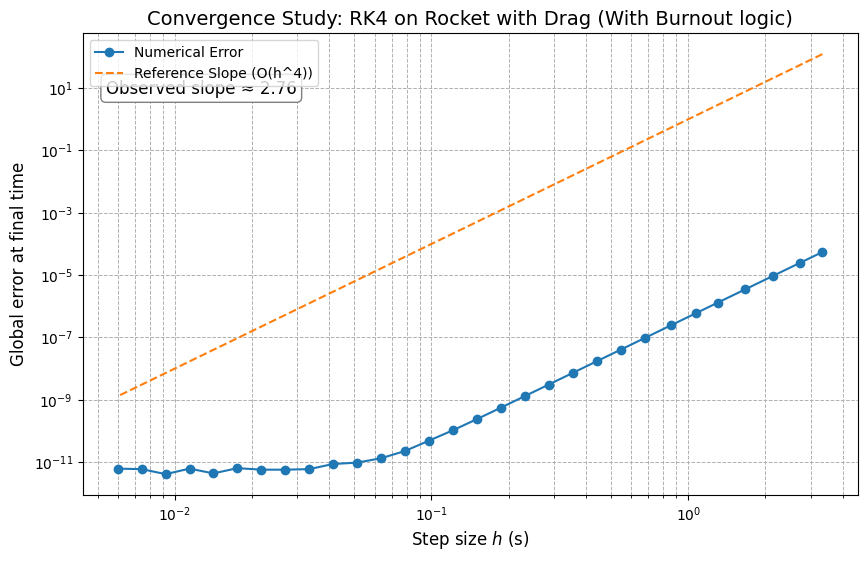

In [28]:
def convergence_study():
    t_max = 30
    y0 = np.array([0.0, 0.0])  # Initial [velocity, altitude]

    step_counts = np.round(np.logspace(np.log10(10), np.log10(5000), 30)).astype(int)
    errors = []

    # Reference solution
    t_ref, Y_ref = solve_rk4(rocket_with_drag_and_burnout, y0, t_max, 12800)
    final_ref = Y_ref[-1]

    for N in step_counts:
        t_num, Y_num = solve_rk4(rocket_with_drag_and_burnout, y0, t_max, N)
        final_num = Y_num[-1]
        error = np.linalg.norm(final_num - final_ref, ord=np.inf)
        errors.append(error)

    hs = t_max / (np.array(step_counts) - 1)

    plt.figure(figsize=(10, 6))
    plt.loglog(hs, errors, 'o-', markersize=6, label='Numerical Error')
    plt.loglog(hs, hs**4, '--', label='Reference Slope (O(h^4))')

    plt.xlabel('Step size $h$ (s)', fontsize=12)
    plt.ylabel('Global error at final time', fontsize=12)
    plt.title('Convergence Study: RK4 on Rocket with Drag (With Burnout logic)', fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True, which='both', linestyle='--', linewidth=0.7)

    ax = plt.gca()
    import matplotlib.ticker as ticker
    ax.xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(1, 10)*0.1, numticks=12))
    ax.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(1, 10)*0.1, numticks=12))
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.tick_params(axis='both', which='minor', labelsize=8)

    # Fit slope
    log_h = np.log(hs)
    log_e = np.log(errors)
    slope, intercept, _, _, _ = linregress(log_h, log_e)
    print(f"Observed convergence rate: {slope:.4f}")

    # Add slope annotation
    textstr = f'Observed slope ≈ {slope:.2f}'
    plt.text(0.03, 0.9, textstr, transform=ax.transAxes,
             fontsize=12, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', edgecolor='gray'))

    plt.show()

# Run the convergence study
convergence_study()

### Runtime vs. Global Error Plot Explanation

To evaluate the trade-off between computational cost and accuracy, we measured how long each RK4 simulation took at different step sizes, and compared the global error (measured at final time) to a high-resolution reference solution.

The following steps were used:

1. Solve the rocket dynamics using RK4 for a set of step counts (e.g., 100, 200, ..., 1600).
2. Use `time.time()` to measure runtime of each simulation.
3. Calculate the infinity-norm error at the final time compared to a reference solution with 12,800 steps.
4. Plot **runtime vs. global error** on a log-log scale.
5. Fit a line to the log-log data to observe how runtime scales with accuracy.

## Runtime versus Global Error

Observed runtime scaling with error: slope ≈ -0.38


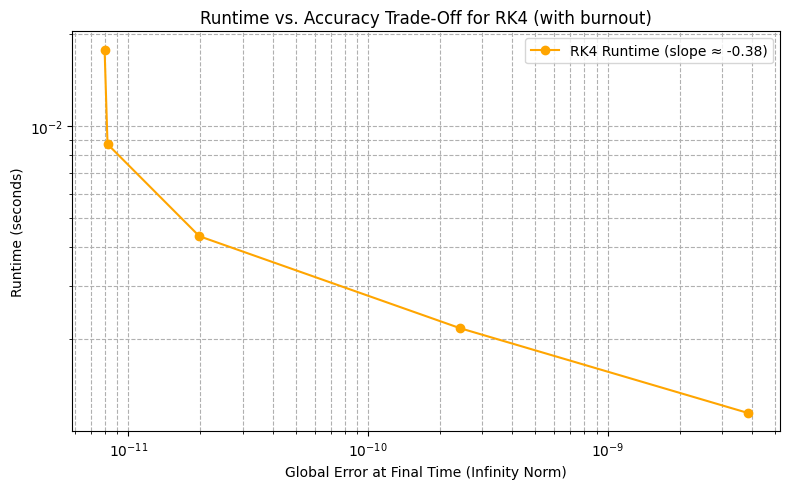

In [24]:
def runtime_vs_error_study():
    t_max = 30
    y0 = np.array([0.0, 0.0])
    #step_counts = np.round(np.logspace(np.log10(100), np.log10(3200), 30)).astype(int)
    step_counts = [100, 200, 400, 800, 1600]

    # Reference solution
    _, Y_ref = solve_rk4(rocket_with_drag_and_burnout, y0, t_max, 12800)
    final_ref = Y_ref[-1]

    runtimes = []
    errors = []

    for N in step_counts:
        h = t_max / (N - 1)
        start = time.time()
        _, Y_num = solve_rk4(rocket_with_drag_and_burnout, y0, t_max, N)
        runtime = time.time() - start

        final_num = Y_num[-1]
        error = np.linalg.norm(final_num - final_ref, ord=np.inf)

        runtimes.append(runtime)
        errors.append(error)

    # Print slope of runtime vs error curve
    slope, _, _, _, _ = linregress(np.log(errors), np.log(runtimes))
    print(f"Observed runtime scaling with error: slope ≈ {slope:.2f}")

    # Plot: Runtime vs. Global Error
    plt.figure(figsize=(8, 5))
    plt.loglog(errors, runtimes, 'o-', label=f'RK4 Runtime (slope ≈ {slope:.2f})', color='orange')
    plt.xlabel('Global Error at Final Time (Infinity Norm)')
    plt.ylabel('Runtime (seconds)')
    plt.title('Runtime vs. Accuracy Trade-Off for RK4 (with burnout)')
    plt.grid(True, which='both', linestyle='--')
    plt.tight_layout()
    plt.savefig("runtime_vs_error_plot.png")
    plt.legend(frameon=True, loc='upper right')
    plt.show()

# Run the runtime vs error study
runtime_vs_error_study()

## Rocket Trajectories

### Trajectories for changing k

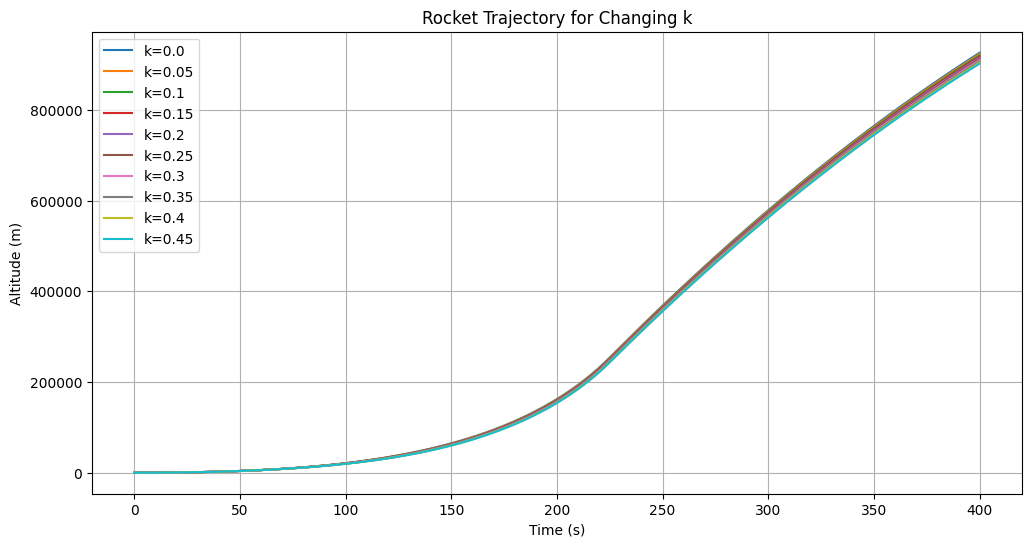

In [37]:
from numpy import random
# Define the rocket dynamics on Earth
def rocket_dynamic_drag(t, y, k, rho0):
    v = y[0]
    h = y[1]

    # --- Constants ---
    g = 9.81
    m0 = 500.0
    mf = 50.0
    mdot = 2.0
    v_e = 3000.0
    H = 8500

    burn_time = (m0 - mf) / mdot
    if t <= burn_time:
        m = m0 - mdot * t
        thrust = v_e * mdot / m
    else:
        m = m0 - mdot * burn_time
        thrust = 0.0

    rho = rho0 * np.exp(-h / H)
    drag = 0.5 * k * rho * v * abs(v) / m

    dvdt = thrust - g - drag
    dhdt = v

    return np.array([dvdt, dhdt])

# Modified RK4 step to account for constant, different dynamics each time
def modified_rk4_step(f, t, y, h, k, rho0):
    k1 = f(t, y, k, rho0)[0:2]
    k2 = f(t + h/2, y + h/2 * k1, k, rho0)[0:2]
    k3 = f(t + h/2, y + h/2 * k2, k, rho0)[0:2]
    k4 = f(t + h, y + h * k3, k, rho0)[0:2]
    return y + (h/6) * (k1 + 2*k2 + 2*k3 + k4)

# Solve rocket dynamics
def modified_solve_rk4(f, y0, t_max, num_steps, k, rho0):
    t_values = np.linspace(0, t_max, num_steps)
    h = t_max / (num_steps - 1)
    Y = np.zeros((num_steps, len(y0)))
    Y[0] = y0
    for i in range(num_steps-1):
        Y[i+1] = modified_rk4_step(f, t_values[i], Y[i], h, k, rho0)
    return t_values, Y

t_max = 400  # total simulation time
num_steps = 5000

# For altitude plot w/ variable k
for i in range(10):
    y0 = np.array([0.0, 0.0])  # initial [velocity, altitude, k, density of air]
    t_values, Y_values = modified_solve_rk4(rocket_dynamic_drag, y0, t_max, num_steps, 0.0 + i*0.05, 0.05)
    altitude = Y_values[:, 1]
    if i == 0:
        plt.figure(figsize=(12, 6))
        plt.plot(t_values, altitude, label='k=' + str(round(0.0 + i*0.05, 2)), linestyle='solid')
        plt.xlabel('Time (s)')
        plt.ylabel('Altitude (m)')
        plt.title('Rocket Trajectory for Changing k')
        plt.legend()
        plt.grid()
    else:
        plt.plot(t_values, altitude, label='k=' + str(round(0.0 + i*0.05, 2)), linestyle='solid')
        plt.legend()


### Trajectories for changing rho0

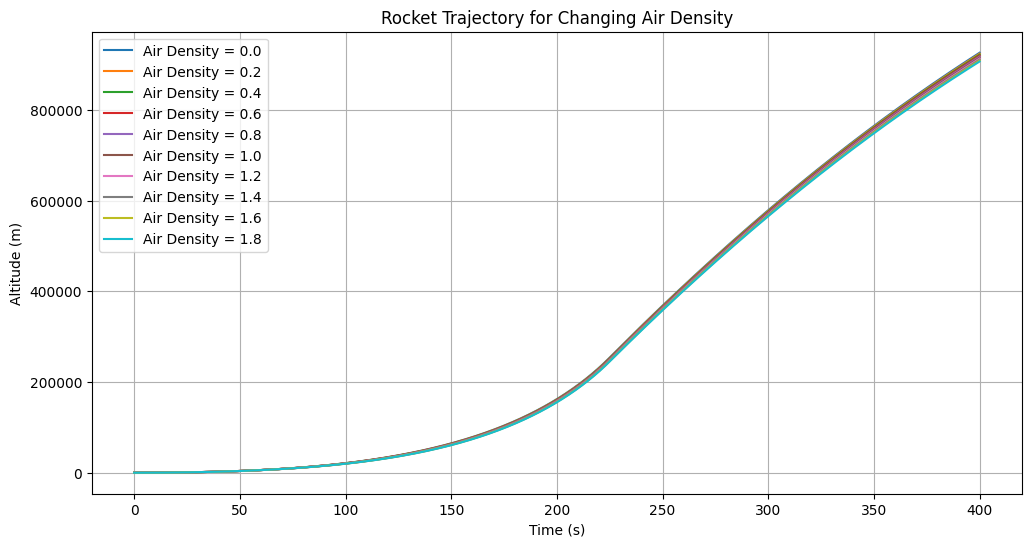

In [38]:
# For altitude w/ variable rho0
for i in range(10):
    y0 = np.array([0.0, 0.0])  # initial [velocity, altitude, k, density of air]
    t_values, Y_values = modified_solve_rk4(rocket_dynamic_drag, y0, t_max, num_steps, 0.01, 0.0 + i*0.20)
    altitude = Y_values[:, 1]
    if i == 0:
        plt.figure(figsize=(12, 6))
        plt.plot(t_values, altitude, label='Air Density = ' + str(round(0.0 + i*0.20, 2)), linestyle='solid')
        plt.xlabel('Time (s)')
        plt.ylabel('Altitude (m)')
        plt.title('Rocket Trajectory for Changing Air Density')
        plt.legend()
        plt.grid()
    else:
        plt.plot(t_values, altitude, label='Air Density = ' + str(round(0.0 + i*0.20, 2)), linestyle='solid')
        plt.legend()

### Error in k and rh0 versus drag factor magnitude

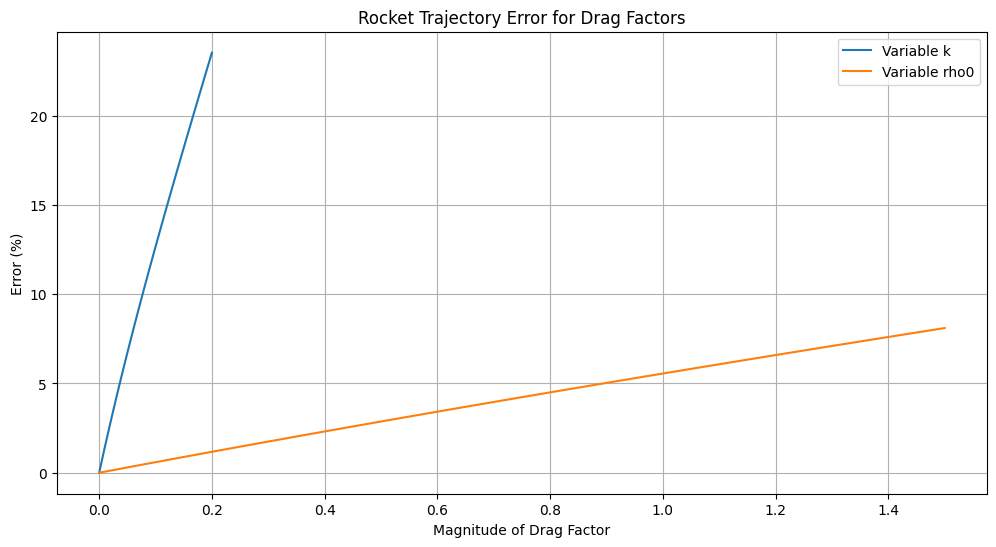

In [45]:
# For error with both
k = []
error_k = []
rho0 = []
error_rho0 = []
for i in range(21):
    # For any range of values here
    y0 = np.array([0.0, 0.0])  # initial [velocity, altitude, k, density of air]
    t_values_1, Y_values_1 = modified_solve_rk4(rocket_dynamic_drag, y0, t_max, num_steps, 0.05, 0.0 + i*0.075)
    t_values_2, Y_values_2 = modified_solve_rk4(rocket_dynamic_drag, y0, t_max, num_steps, 0.0 + i*0.01, 1.225)
    altitude_1_max = Y_values_1[:, 1][len(Y_values_1[:, 1]) - 1]
    altitude_2_max = Y_values_2[:, 1][len(Y_values_2[:, 1]) - 1]

    # Compare to no drag
    t_values, Y_values = modified_solve_rk4(rocket_dynamic_drag, y0, t_max, num_steps, 0.0, 0.0)
    altitude_ideal_max = Y_values[:, 1][len(Y_values[:, 1]) - 1]

    k.append(0.0 + i*0.01)
    rho0.append(0.0 + i*0.075)
    error_k.append(abs((altitude_ideal_max - altitude_2_max)/altitude_ideal_max)*100)
    error_rho0.append(abs((altitude_ideal_max - altitude_1_max)/altitude_ideal_max)*100)


plt.figure(figsize=(12, 6))
plt.plot(k, error_k, label='Variable k', linestyle='solid')
plt.plot(rho0, error_rho0, label='Variable rho0', linestyle='solid')
plt.xlabel('Magnitude of Drag Factor')
plt.ylabel('Error (%)')
plt.title('Rocket Trajectory Error for Drag Factors')
plt.legend()
plt.grid()

### Rocket trajectory for changing final mass

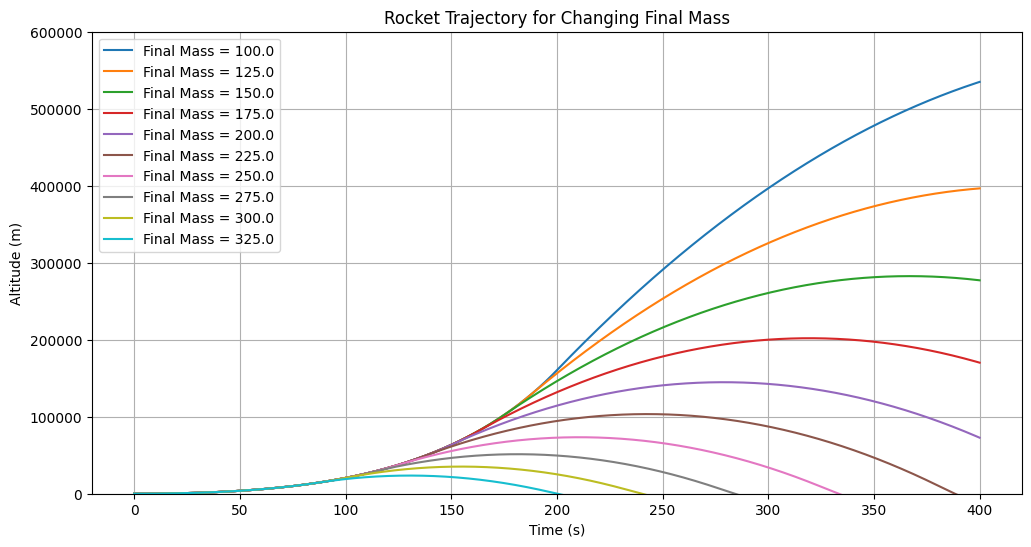

In [48]:
# Define the rocket dynamics on Earth
def rocket_dynamic_init(t, y, initial_cond):
    v = y[0]
    h = y[1]

    # --- Constants ---
    g = 9.81
    m0 = 500
    mf = initial_cond[0]
    mdot = initial_cond[1]
    v_e = initial_cond[2]
    A = 0.01
    cd = 0.75
    rho0 = 1.225
    H = initial_cond[3]

    burn_time = (m0 - mf) / mdot
    if t <= burn_time:
        m = m0 - mdot * t
        thrust = v_e * mdot / m
    else:
        m = m0 - mdot * burn_time
        thrust = 0.0

    rho = rho0 * np.exp(-h / H)
    drag = 0.5 * A * rho * rho * v * abs(v) / m

    dvdt = thrust - g - drag
    dhdt = v

    return np.array([dvdt, dhdt])

# Modified RK4 step to account for constant, different dynamics each time
def mod_rk4_step(f, t, y, h, initial_cond):
    k1 = f(t, y, initial_cond)[0:2]
    k2 = f(t + h/2, y + h/2 * k1, initial_cond)[0:2]
    k3 = f(t + h/2, y + h/2 * k2, initial_cond)[0:2]
    k4 = f(t + h, y + h * k3, initial_cond)[0:2]
    return y + (h/6) * (k1 + 2*k2 + 2*k3 + k4)

# Solve rocket dynamics
def mod_solve_rk4(f, y0, t_max, num_steps, initial_cond):
    t_values = np.linspace(0, t_max, num_steps)
    h = t_max / (num_steps - 1)
    Y = np.zeros((num_steps, len(y0)))
    Y[0] = y0
    for i in range(num_steps-1):
        Y[i+1] = mod_rk4_step(f, t_values[i], Y[i], h, initial_cond)
    return t_values, Y

t_max = 400 # total simulation time
num_steps = 5000

# For altitude w/ variable mf
for i in range(10):
    y0 = np.array([0.0, 0.0])  # initial [velocity, altitude, k, density of air]
    initial_condition = np.array([100.0 + 25*i, 2.0, 3000, 8500])
    t_values, Y_values = mod_solve_rk4(rocket_dynamic_init, y0, t_max, num_steps, initial_condition)
    altitude = Y_values[:, 1]
    if i == 0:
        plt.figure(figsize=(12, 6))
        plt.plot(t_values, altitude, label='Final Mass = ' + str(round(100.0 + 25*i, 2)), linestyle='solid')
        plt.xlabel('Time (s)')
        plt.ylabel('Altitude (m)')
        plt.title('Rocket Trajectory for Changing Final Mass')
        plt.legend()
        plt.grid()
        plt.ylim(0,600000)
    else:
        plt.plot(t_values, altitude, label='Final Mass = ' + str(round(100.0 + 25*i, 2)), linestyle='solid')
        plt.legend()

### Error with changing initial conditions in final state with 10% increments

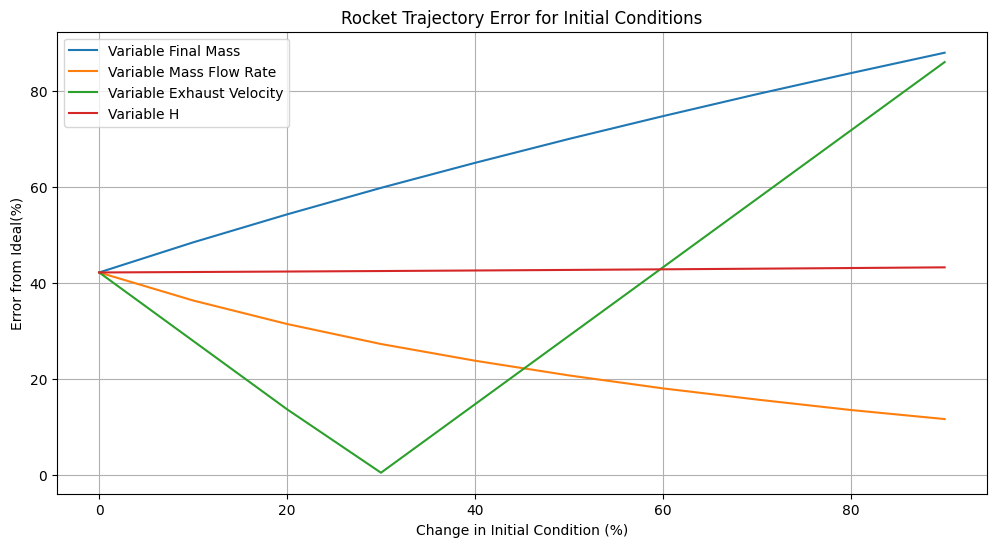

In [49]:
# For error with changing initial conditions in final state with 10% increments
mass_final = []
error_mass_final = []
mdot = []
error_mdot = []
v_e = []
error_v_e = []
H = []
error_H = []
for i in range(10):
    # For any range of values here
    y0 = np.array([0.0, 0.0])  # initial [velocity, altitude, k, density of air]
    initial_condition = np.array([100.0, 2.0, 3000, 8500])
    delta_mf = np.array([0.1*initial_condition[0]*i, 0, 0, 0])
    delta_mdot = np.array([0, 0.1*initial_condition[1]*i, 0, 0])
    delta_v_e = np.array([0, 0, 0.1*initial_condition[2]*i, 0])
    delta_H = np.array([0, 0, 0, 0.1*initial_condition[3]*i])

    t_values_mfinal, Y_values_mfinal = mod_solve_rk4(rocket_dynamic_init, y0, t_max, num_steps, initial_condition + delta_mf)
    t_values_mdot, Y_values_mdot = mod_solve_rk4(rocket_dynamic_init, y0, t_max, num_steps, initial_condition + delta_mdot)
    t_values_v_e, Y_values_v_e = mod_solve_rk4(rocket_dynamic_init, y0, t_max, num_steps, initial_condition + delta_v_e)
    t_values_H, Y_values_H = mod_solve_rk4(rocket_dynamic_init, y0, t_max, num_steps, initial_condition + delta_H)
    altitude_mf_max = Y_values_mfinal[:, 1][len(Y_values_mfinal[:, 1]) - 1]
    altitude_mdot_max = Y_values_mdot[:, 1][len(Y_values_mdot[:, 1]) - 1]
    altitude_v_e_max = Y_values_v_e[:, 1][len(Y_values_v_e[:, 1]) - 1]
    altitude_H_max = Y_values_H[:, 1][len(Y_values_H[:, 1]) - 1]

    # Compare to no drag
    t_values, Y_values = modified_solve_rk4(rocket_dynamic_drag, y0, t_max, num_steps, 0.0, 0.0)
    altitude_ideal_max = Y_values[:, 1][len(Y_values[:, 1]) - 1]

    mass_final.append(10*i)
    mdot.append(10*i)
    v_e.append(10*i)
    H.append(10*i)

    error_mass_final.append(abs((altitude_ideal_max - altitude_mf_max)/altitude_ideal_max)*100)
    error_mdot.append(abs((altitude_ideal_max - altitude_mdot_max)/altitude_ideal_max)*100)
    error_v_e.append(abs((altitude_ideal_max - altitude_v_e_max)/altitude_ideal_max)*100)
    error_H.append(abs((altitude_ideal_max - altitude_H_max)/altitude_ideal_max)*100)

plt.figure(figsize=(12, 6))
plt.plot(mass_final, error_mass_final, label='Variable Final Mass', linestyle='solid')
plt.plot(mdot, error_mdot, label='Variable Mass Flow Rate', linestyle='solid')
plt.plot(v_e, error_v_e, label='Variable Exhaust Velocity', linestyle='solid')
plt.plot(H, error_H, label='Variable H', linestyle='solid')
plt.xlabel('Change in Initial Condition (%)')
plt.ylabel('Error from Ideal(%)')
plt.title('Rocket Trajectory Error for Initial Conditions')
plt.legend()
plt.grid()